# Генератор на карти Starcraft: Brood War

Това е курсова работа за курса **Практическо въведение в машинното самообучение с Python** воден във **ФМИ** през зимния семестър на 2018/2019.

## За играта Starcraft

**Starcraft** е стратегическа компютърна игра издадена през 1998 година. Наследник е на играта Warcraft 2 (издадена - 1995) и ползва модифицирана версия на енджина ѝ. Поради тази причина двете игри споделят много общи технически (и не само) характеристики. Около 2000-ната година играта придобива популярност в Южна Корея, където се появяват турнири с телевизионно излъчване и професионални играчи. Скоро след това играта започва да се играе на професионално и на международно ниво. Към момента - 20 години по-късно - играта продължава да бъде обновявана от създателите ѝ и продължават да бъдат организирани периодични турнири в Южна Корея.

## Правила на играта

В началото на всяка игра на Starcraft играчът избира една измежду три различни раси, след което събира ресурси, развива своята база и войска и воюва с други играчи и/или инстанции на изкуствен интелект. Играта се играе до унищожаване на чуждата база или предаване. Битките се водят върху предварително подбрани карти.

## Еволюция

За професионалните игри е важен балансът между трите различни раси. За целта в първите години след излизането на играта, във всяка нова версия расите биват променяни по малко, за да бъдат по-равностойни. Това продължава до версия 1.08 издадена на 20.05.2001. От тогава до сега новите версии не променят начина на игра, а поправят бъгове и подобряват други аспекти на играта.

За сметка на това грижата за баланса се прехвърля върху картите. Всяка карта трябва да успее да отчете предимствата и недостатъците на всяка раса, за да постигне подходящ баланс. Съществуват сайтове, пазещи статистики за победи/загуби за всяка раса за всяка карта. Често карти биват ревизирани, за да бъде подобрен балансът на тях.

В допълнение на това, за да продължава играта да бъде интересна на зрителите и играчите, наборът от актуални професионални карти бива постоянно променян от организаторите на турнири.

## Технологията около картите

Играта използва 2:1 изометрична перспектива изглеждаща горе-долу по този начин:
![2:1 изометрична перспектива](http://www.clockworkchilli.com/shared/iso1.png)

Всеки от ромбовете е широк 128 пиксела и висок 64 пиксела. Картите са правоъгълни, като ромбовете по краищата са изрязани.

Любопитното е, че самите плочки не отговарят на ромбовете, а са квадрати с размер 32x32 пиксела. Това е наследство от Warcraft 2 енджина. Растерът от плочки наложен върху част от карта изглежда така:
![растер](https://vignette.wikia.nocookie.net/staredit-network/images/9/91/SC1_Terrain_Tile_Grid.png/revision/latest?cb=20170906150056)

Самите плочки имат свойства закачени на тях. Например - дали може да се строи сграда върху дадена плочка.

Възможно е също свойства да бъдат закачени за част от плочка. Например - дали върху част от плочка може да се преминава с войска. Това се случва върху по-фин растер с размер 8x8, изглеждащ така:
![фин растер](http://www.codeofhonor.com/blog/wp-content/uploads/2013/02/Starcraft.jpg)

Всичко това води до нуждата от сложни правила за снаждане на квадратни плочки. Въпросните правила са имплементирани в редактора на карти, съпътстващ играта. И докато през годините много от детайлите на играта (които са затворена технология) са разгадани и публикувани, правилата за снаждане на плочки - не са.

## Цели

  - **Освновна цел**: да обучим невронна мрежа да снажда плочки.
  - **Допълнителна цел**: да обучим невронна мрежа да генерира карти с известно ниво на симетрия.
  - **Нереалистична цел**: да обучим невронна мрежа да генерира "справедливи" и "балансирани" карти.

In [1]:
import matplotlib.pyplot as plt
import mpq
import numpy as np
import os
import sys

sys.path.append('../model')

import config
from game import *
from tileset import Tileset

In [2]:
%matplotlib inline

# Данни

За този проект не разполагаме с готов dataset. Ще си сглобим dataset, парсвайки картите вградени в играта StarCraft, както и разни допълнителни външни карти. Всяка от тези карти представлява растер от плочки.

В допълнение ще парснем и информацията за tileset-овете в играта. Те съдържат информацията за всяка от плочките. Тях в последствие ще превърнем във feature-и, които ще използваме в RNN.

Логиката за парсване на карти се намира в модула `scenario`. За tileset-и -- в модула `tileset`. В модула `config` пише пътищата към играта StarCraft и има допълнителен списък от директории с карти.

In [3]:
scenarios = []
game = Game(config.STARCRAFT_ROOT)
scenarios += game.process_game_scenarios()
for directory in config.MAP_DIRECTORIES:
    scenarios += game.process_scenarios(directory)

Броят на всички карти е:

In [4]:
len(scenarios)

603

Броят на всички плочки във всички карти е:

In [5]:
sum(map(lambda x: x.width * x.height, scenarios))

13833216

Броят уникални плочки за всеки tileset е:

In [6]:
for tileset in Tileset:
    print('%s: %d' % (tileset.name, len(tileset.tiles)))

BADLANDS: 26640
SPACE_PLATFORM: 24208
INSTALLATION: 20240
ASHWORLD: 20192
JUNGLE: 25248
DESERT: 24320
ARCTIC: 22640
TWILIGHT: 23904


# Визуализация

Ще въведем някакъв произволен начин за изобразяване на плочки чрез функцията `get_height_map`.

In [7]:
@np.vectorize
def get_height_map(tile):

    @np.vectorize
    def minitile_heights(minitile):
        return minitile.height

    @np.vectorize
    def minitile_walkability(minitile):
        return minitile.walkable

    return np.average(minitile_heights(tile.minitiles)) + \
           np.average(minitile_walkability(tile.minitiles) * 0.5) + \
           tile.buildable * 0.2 + 0.0001

Нека изберем карти в джунглата с размер 128 Х 128 за четирима играчи...

In [8]:
four_player_jungle_scenarios = [x for x in scenarios if x.alliances == x.human_players == 4 and x.tileset == Tileset.JUNGLE and x.width == x.height == 128]

len(four_player_jungle_scenarios)

97

И нека визуализираме някаква част от тях:

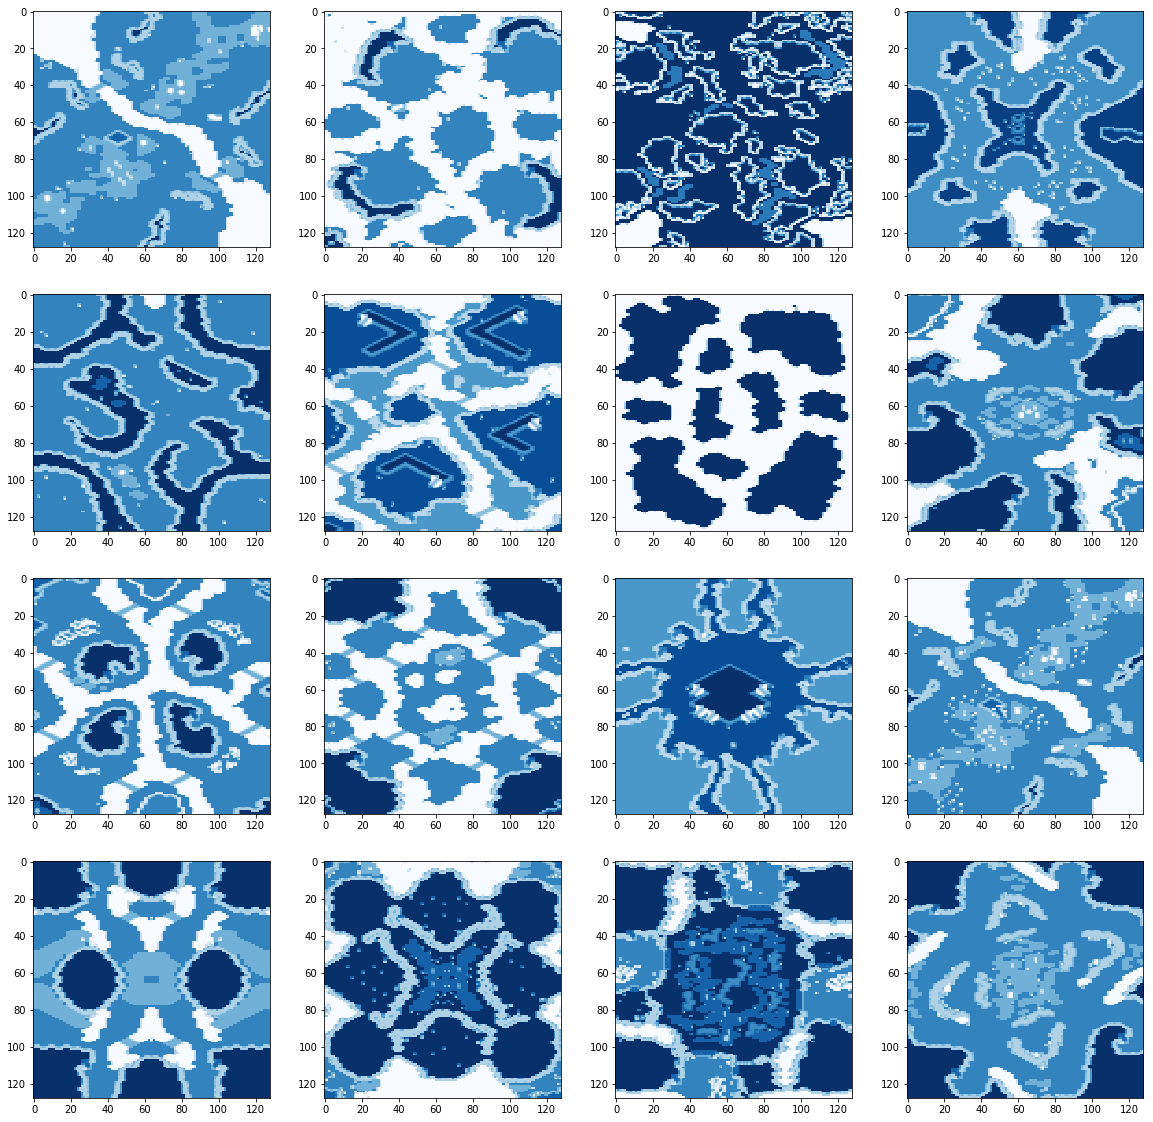

In [9]:
plt.figure(figsize=(20, 20))

for i in range(16):
    scenario = four_player_jungle_scenarios[i]
    height_map = get_height_map(scenario.tiles)

    plt.subplot(4, 4, i + 1)
    plt.imshow(height_map, cmap=plt.cm.Blues)

plt.show()

Изглеждат прилично. Някой от тях - дори разпознаваемо.

Нека визуализираме и няколко не-квадратни карти, за да сме сигурни, че всичко е ок и с тях...

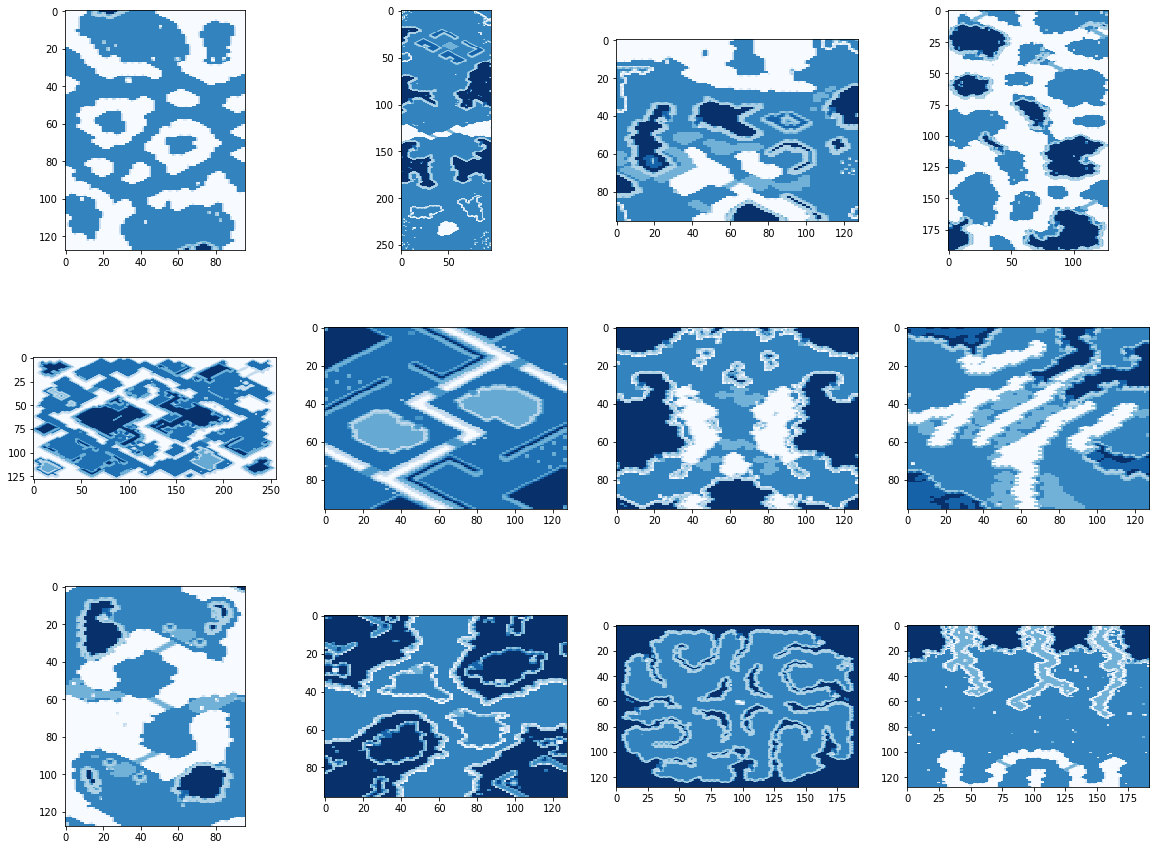

In [10]:
non_square_scenarios = [x for x in scenarios if x.width != x.height]

plt.figure(figsize=(20, 15))

for i in range(12):
    scenario = non_square_scenarios[i]
    height_map = get_height_map(scenario.tiles)

    plt.subplot(3, 4, i + 1)
    plt.imshow(height_map, cmap=plt.cm.Blues)

plt.show()

# Други данни

Картите имат и разни допълнителни свойства освен видяните до сега.

In [11]:
blood_bath = next(filter(lambda x: x.name == 'Blood Bath', scenarios))
print(blood_bath.version)
print('\n--------------------\n')
print(blood_bath.name)
print('\n--------------------\n')
print(blood_bath.description)

ScenarioVersion.STARCRAFT_1_00

--------------------

Blood Bath

--------------------

Suggested Players: 2 or 4

A bloody little war.


# Истински цветове

Имаме и информация за истинските цветове на плочките. С нея можем да ги визуализираме така, както биха се появили в играта. Това ще бъде интересно за разглеждане, като (ако) невронната мрежа се научи да ги снажда правилно.

## Minitile

Мини-плочката е най-малката съставна част. Тя е с размер 8x8 пиксела и съдържа единствено визуална информация.

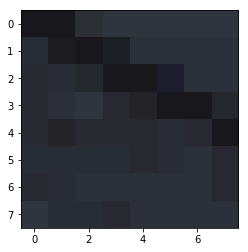

In [12]:
plt.imshow(blood_bath.tiles[20, 20].minitiles[0, 0].graphics);

## Megatile

Истинската плочка. Съдържа 4x4 мини-плочки, с което получаваме размер 32x32 пиксела. Може да има свойства асоциирани с всяка мини-плочка (например: височина). Може да има и свойства с цялата плочка (например: може ли да се строи върху плочката).

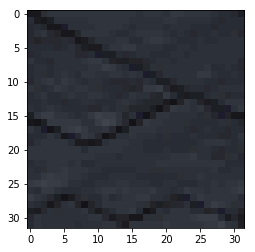

In [13]:
plt.imshow(blood_bath.tiles[20, 20].graphics);

Може да има свойства асоциирани с всяка мини-плочка (например: височина)

In [14]:
[property for property in dir(blood_bath.tiles[0, 0].minitiles[0, 0]) if not property.startswith('__')]

['blocks_view',
 'graphics',
 'graphics_flipped',
 'graphics_id',
 'height',
 'ramp',
 'walkable']

Може да има и свойства асоциирани с цялата плочка (например: може ли да се строи върху плочката).

In [15]:
[property for property in dir(blood_bath.tiles[0, 0]) if not property.startswith('__')]

['buildable', 'graphics', 'index', 'minitiles']

## Scenario

Можем да визуализираме и цели карти...

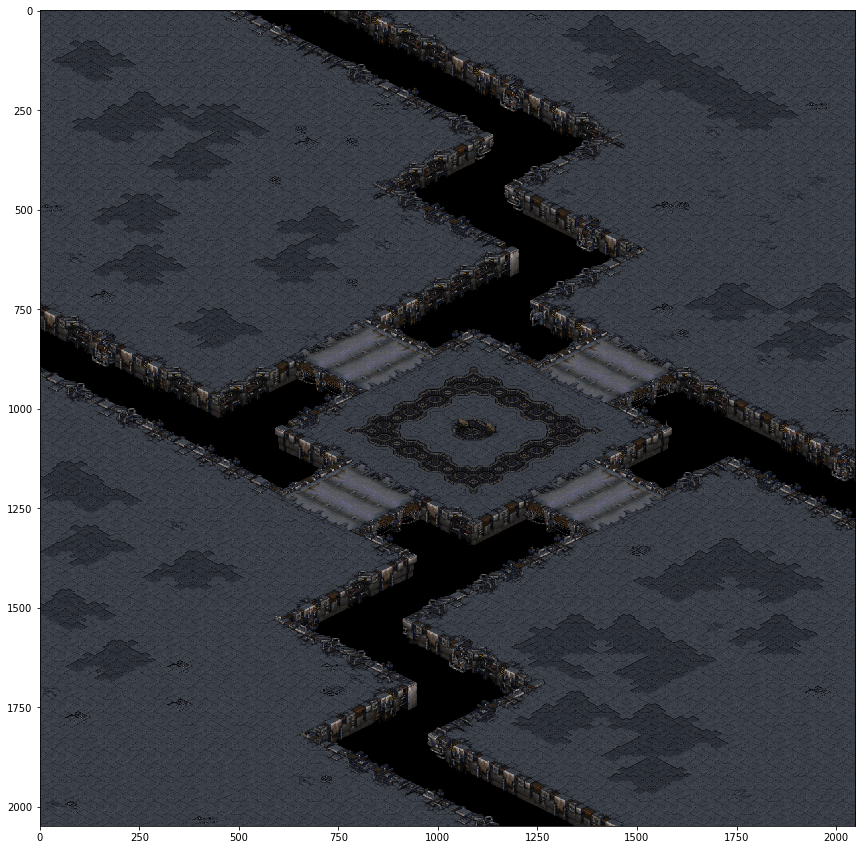

In [16]:
plt.figure(figsize=(15, 15))
plt.imshow(blood_bath.graphics);

... или пък части от тях:

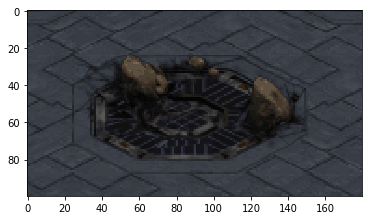

In [17]:
plt.imshow(blood_bath.graphics[1000:1100, 1000:1180]);